In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import time
import torch.utils.data
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import pandas as pd
from models import *
import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])


# Load CIFAR 10 Data


In [2]:


# # Function to load a batch file and return a dictionary
# def unpickle(file):
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo, encoding='bytes')
#     return dict

# # Load dataset, combine batches, split, and visualize images
# def load_and_prepare_data():
#     # Load and combine the training batches
#     data_batches, label_batches = [], []
#     for i in range(1, 6):
#         batch = unpickle(f'data/KaggleData/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
#         data_batches.append(batch[b'data'])
#         label_batches.append(batch[b'labels'])
#     X, y = np.concatenate(data_batches), np.concatenate(label_batches)
    
#     # Split into training and validation sets (80-20 split)
#     return train_test_split(X, y, test_size=0.2, random_state=42)

# X_train, X_val, y_train, y_val = load_and_prepare_data()

# # Custom Dataset class for CIFAR-10
# class CIFAR10Dataset(Dataset):
#     def __init__(self, data, labels, transform=None):
#         self.data = data
#         self.labels = labels
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.labels)
    
#     def __getitem__(self, idx):
#         image = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
#         image = Image.fromarray(image.astype('uint8'), 'RGB')
#         if self.transform:
#             image = self.transform(image)
#         return image, self.labels[idx]

# # Define transformations
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
# transformations = {
#     'train': transforms.Compose([
#         transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
#         transforms.RandomHorizontalFlip(), 
#         transforms.RandomRotation(degrees=15),
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change brightness, contrast, and saturation
#         transforms.ToTensor(), 
#         transforms.RandomApply([transforms.RandomErasing()], p=0.5),  # Randomly apply the Cutout technique with a 50% probability
#         transforms.Normalize(*stats)]), 
#     'valid': transforms.Compose([
#         transforms.ToTensor(), 
#         transforms.Normalize(*stats)])
# }

# # Create datasets and DataLoader instances
# datasets = {
#     'train': CIFAR10Dataset(X_train, y_train, transform=transformations['train']),
#     'valid': CIFAR10Dataset(X_val, y_val, transform=transformations['valid'])
# }
# loaders = {
#     'train': DataLoader(datasets['train'], batch_size=64, shuffle=True),
#     'valid': DataLoader(datasets['valid'], batch_size=64, shuffle=False)
# }

# print('Amount of Train Data batches: ', len(loaders['train']))
# print('Amount of Valid Data batches: ', len(loaders['valid']))

# print('Amount of training images: ', len(X_train))
# print('Amount of Validation images: ', len(X_val))




In [3]:
# Function to load a batch file and return a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load dataset, combine batches, split, and visualize images
def load_and_prepare_data():
    # Load and combine the training batches
    data_batches, label_batches = [], []
    for i in range(1, 6):
        batch = unpickle(f'data/KaggleData/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
        data_batches.append(batch[b'data'])
        label_batches.append(batch[b'labels'])
    X, y = np.concatenate(data_batches), np.concatenate(label_batches)
    
    # Split into training and validation sets (80-20 split)
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = load_and_prepare_data()

# Define transformations
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformations = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(), 
        transforms.RandomApply([transforms.RandomErasing()], p=0.5),
        transforms.Normalize(*stats)]),
        
    'valid': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)]),
        
    # Normalization only for 'train_Default' scenario
    'normalization_only': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)])
}

# Adjusting the CIFAR10Dataset class initialization to accept 'data_mode'
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None, data_mode='default'):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.data_mode = data_mode
        if data_mode == 'train_Enhanced':
            self.data = np.concatenate((self.data, self.data), axis=0)
            self.labels = np.concatenate((self.labels, self.labels), axis=0)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.data_mode == 'train_Enhanced' and idx >= len(self.labels) // 2:
            transform = transformations['train']
        else:
            transform = self.transform
        image = self.data[idx % len(self.labels)].reshape(3, 32, 32).transpose(1, 2, 0)
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        image = transform(image)
        return image, self.labels[idx % len(self.labels)]

# Create datasets and DataLoader instances
datasets = {
    'train_Enhanced': CIFAR10Dataset(X_train, y_train, transform=transformations['normalization_only'], data_mode='train_Enhanced'),
    'valid': CIFAR10Dataset(X_val, y_val, transform=transformations['valid'])
}

# Update loaders for each dataset
loaders = {
    'train_Enhanced': DataLoader(datasets['train_Enhanced'], batch_size=64, shuffle=True),
    'valid': DataLoader(datasets['valid'], batch_size=64, shuffle=False)
}

print('Amount of Train Data batches (Enhanced):', len(loaders['train_Enhanced']))
print('Amount of Valid Data batches:', len(loaders['valid']))

print('Amount of training images (Enhanced):', len(datasets['train_Enhanced']))
print('Amount of Validation images:', len(X_val))


Amount of Train Data batches (Enhanced): 1250
Amount of Valid Data batches: 157
Amount of training images (Enhanced): 80000
Amount of Validation images: 10000


In [4]:
first_batch_images, first_batch_labels = next(iter(loaders['train_Enhanced']))
print(f"First batch images shape: {first_batch_images.shape}")
print(f"First batch labels shape: {first_batch_labels.shape}")


First batch images shape: torch.Size([64, 3, 32, 32])
First batch labels shape: torch.Size([64])


Training Images:


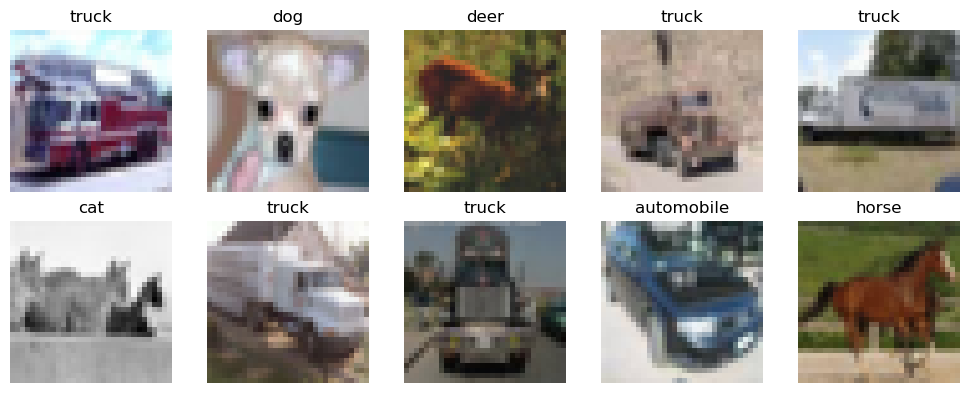

Validation Images:


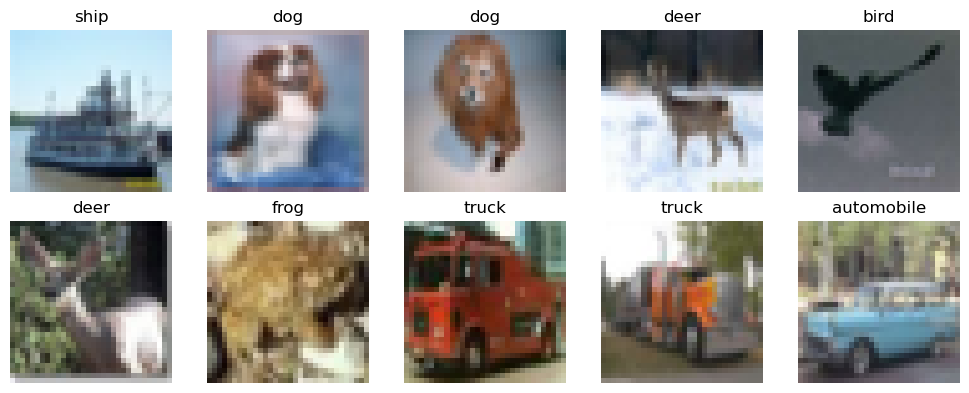

In [5]:
#visualize:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage
from random import sample

# Define a function to show images in a grid
def show_images(images, labels, classes, rows=2, cols=5, scale=2):
    fig, axes = plt.subplots(rows, cols, figsize=(scale*cols, scale*rows))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        img = img.reshape(3, 32, 32).transpose(1, 2, 0)  # Convert to HxWxC format
        if np.max(img) > 1:  # Assume the image is in the range [0, 255]
            img = img / 255.0
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(classes[label])
    plt.tight_layout()
    plt.show()

# Classes in CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Randomly select 10 images and their labels from training set
indices_train = sample(range(len(X_train)), 10)
images_train = X_train[indices_train]
labels_train = y_train[indices_train]

# Randomly select 10 images and their labels from validation set
indices_val = sample(range(len(X_val)), 10)
images_val = X_val[indices_val]
labels_val = y_val[indices_val]

# Display training images
print("Training Images:")
show_images(images_train, labels_train, classes)

# Display validation images
print("Validation Images:")
show_images(images_val, labels_val, classes)



# Model finetuning

### 1st  Test: Architecture Test:

- Test number of Layers (4 Training Runs): 

     train with 2,3,4,5 layers [same amount of blocks for all layers [2,2,2,2], Similar amount of Conv-featuremaps for each layer [2layers: 64,256],[3 Layers: 64,128,256],[4Layers: 64,128,128,256]], [5 Layers: 64,64,128,128,256] 

- Test best Config of Blocks per Layer (4 Training Runs):

     Suppose the prev. test returned that 4 layers gives best valid accuracy: Run through training with 4 permutations of Blocks Per Layers (only choose either 3 or 2 blocks per layer to keep it simple) 

Goal: Figure out best Architecture by finding optimal Amount of Layers, and optimal Amount of Blocks per Layer.

Guidelines for Architecture Test: No Dropouts, and no Data Augmentation (but normalization)

### 2nd Test: Training Parameter Gridsearch

2nd Test: Hyperparameter Gridsearch:
- Learning Rate (4 tests)

     LR set to [0.1, 0.01, 0.001, 0.0001] (while using ADAM as Optimizer, no LR scheduler)

- Optimizer: (4 tests)
     
     Having figured out best LR, test different Optimizers: SGD, ADAM, ADAMW(0.01) (3 Training Runs)
     if ADAMW returns best Valid Acc. figure out which weight decay to use [0.1,0.01,0.001,0.0001] 

- Exponential scheduler or not (2 differenttests. Exponential LR with gamma 0.98)

Goal: Figure out best set of training-setup

### 3rd Test: Data ingestion Method: 
- Batchsize [ 32, ,64, 128, 256] (4 tests)
- Augmentation (Random Flipping, cropping) (3 Tests)

     1. No Augmentation applied, 
     2. With Random Flipping and Cropping, 
     3. With Random and Cropping but copying the Altered images on top of the original training data (increase training images from 40k to 80k)     
     



In [6]:
def Resnet3_443Exp():
    return ResNet3(BasicBlock, [4,4,3])

model = Resnet3_443Exp()

total_paramsResnet3_443 = sum(p.numel() for p in model.parameters())
print(f"Total parameters modelResnet3_443: {total_paramsResnet3_443}")

# Move the model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

model.to(device)

Total parameters modelResnet3_443: 4697162
NVIDIA GeForce RTX 4070


ResNet3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [7]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1, filter_size=3):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=filter_size, stride=stride, padding=filter_size//2, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out
    
# class ResNet3(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=10):
#         super(ResNet3, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, filter_size=5)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, filter_size=3)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, filter_size=3)

#         self.avgpool = nn.AvgPool2d(8)
#         self.linear = nn.Linear(256 * block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride, filter_size):
#         strides = [stride] + [1] * (num_blocks - 1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride, filter_size))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)  # Flatten the output for the linear layer
#         out = self.linear(out)
#         return out

# def Resnet3_443_Exp():
#     return ResNet3(BasicBlock, [4,4,3])      
# model = Resnet3_443_Exp() #changed to .4, prev .3
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total parameters: {total_params}")
# # Move the model to CUDA device if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.get_device_name(0))
# model.to(device)

In [8]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0):
#         super(BasicBlock, self).__init__()
#         self.dropout_rate = dropout_rate
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )
#         self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         if self.dropout:
#             out = self.dropout(out)
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=10,dropout_rate=0.0):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
#         self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2, dropout_rate=dropout_rate)
#         self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2, dropout_rate=dropout_rate)
#         self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2, dropout_rate=dropout_rate)
    
#         self.linear = nn.Linear(256*block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride, dropout_rate=0.0):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride, dropout_rate=dropout_rate))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = F.avg_pool2d(out, 4)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out

# # Adjusting the number of blocks to reduce the total parameters
# def ResNetModified(dropout_rate=0.0):
#     return ResNet(BasicBlock, [6, 6, 3, 3], dropout_rate=dropout_rate) #numbers indicate amount of blocks per layer. 1st 3, 2nd 2, 3rd 3, 4th 3,  

# def test():
#     net = ResNetModified()
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())

# test()

# # Instantiate the model
# model = ResNetModified(dropout_rate=0.0) #changed to .4, prev .3
# #Total Parameters in model
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total parameters: {total_params}")
# # Move the model to CUDA device if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.get_device_name(0))
# model.to(device)

In [9]:
# """ResNet in PyTorch.

# For Pre-activation ResNet, see 'preact_resnet.py'.

# Reference:
# [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
#     Deep Residual Learning for Image Recognition. arXiv:1512.03385
# """

# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(
#             in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
#                                stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out


# class ThreeLayerResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=10):
#         super(ThreeLayerResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
#                                stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.linear = nn.Linear(256*block.expansion, num_classes)
#         self.pool_kernel_size = 8

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         # out = self.layer4(out)
#         out = F.avg_pool2d(out, self.pool_kernel_size)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out
# model3Layers = ThreeLayerResNet(BasicBlock,[2,3,3]) #changed to .4, prev .3
# #Total Parameters in model
# total_params = sum(p.numel() for p in model3Layers.parameters())
# print(f"Total parameters: {total_params}")
# # Move the model to CUDA device if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.get_device_name(0))
# model3Layers.to(device)


# def test():
#     net = ThreeLayerResNet(BasicBlock,[2,3,3])
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())
# test()

In [10]:
# class ResNet3(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=10):
#         super(ResNet3, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.linear = nn.Linear(256*block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out

# def Resnet3():
#     return ResNet3(BasicBlock, [8, 4,3])

# def test():
#     net = Resnet3()
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())

# test()


# # Instantiate the model
# model = Resnet3() #changed to .4, prev .3
# #Total Parameters in model
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total parameters: {total_params}")
# # Move the model to CUDA device if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.get_device_name(0))
# model.to(device)

# Training

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import time

def train_and_evaluate_model(model, model_name, loaders, device, weight_decay, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=weight_decay)
    scheduler = ExponentialLR(optimizer, gamma=0.98)

    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders["train_Enhanced"]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),0.1)

            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item() * inputs.size(0)
            num_batches += 1

            _, predicted = torch.max(outputs.data, 1)
            total_correct_train += (predicted == labels).sum().item()
            num_train_examples += labels.size(0)

            if (i + 1) % 100 == 0 or i == len(loaders["train_Enhanced"]) - 1:
                print(f"{model_name}, train_Enhanced - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders['train_Enhanced'].dataset)} "
                      f"({100. * (i + 1) / len(loaders['train_Enhanced']):.0f}%)], Weight Decay: {weight_decay},  Loss: {running_loss / num_batches:.4f}")

        avg_train_loss = total_train_loss / num_train_examples  # Correct average training loss calculation
        train_loss_history.append(avg_train_loss)

        train_accuracy = 100. * total_correct_train / num_train_examples
        train_accuracy_history.append(train_accuracy)

        model.eval()
        total_valid_loss, total_correct_valid, num_valid_batches = 0.0, 0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() * inputs.size(0)  # Update to multiply by batch size for total loss
            _, predicted = torch.max(outputs.data, 1)
            total_correct_valid += (predicted == labels).sum().item()
            num_valid_batches += 1

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)  # Correct average validation loss calculation
        valid_loss_history.append(avg_valid_loss)

        valid_accuracy = 100. * total_correct_valid / len(loaders['valid'].dataset)
        valid_accuracy_history.append(valid_accuracy)

        print(f"End of Epoch: {epoch}, Avg. Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            model_path = f'{model_name}_Final_best_model.pth'
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved: {model_path}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"Training completed. Total execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history


Training with weight decay: 1e-05
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [6400/80000 (8%)], Weight Decay: 1e-05,  Loss: 1.9453
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [12800/80000 (16%)], Weight Decay: 1e-05,  Loss: 1.8226
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [19200/80000 (24%)], Weight Decay: 1e-05,  Loss: 1.7382
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [25600/80000 (32%)], Weight Decay: 1e-05,  Loss: 1.6720
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [32000/80000 (40%)], Weight Decay: 1e-05,  Loss: 1.6146
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [38400/80000 (48%)], Weight Decay: 1e-05,  Loss: 1.5680
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [44800/80000 (56%)], Weight Decay: 1e-05,  Loss: 1.5258
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [51200/80000 (64%)], Weight Decay: 1e-05,  Loss: 1.4888
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [57600/80000 (72%)], Weight Decay: 1e-05,  Loss: 1.4564
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [64000/80000 (80%)], Weight Decay:

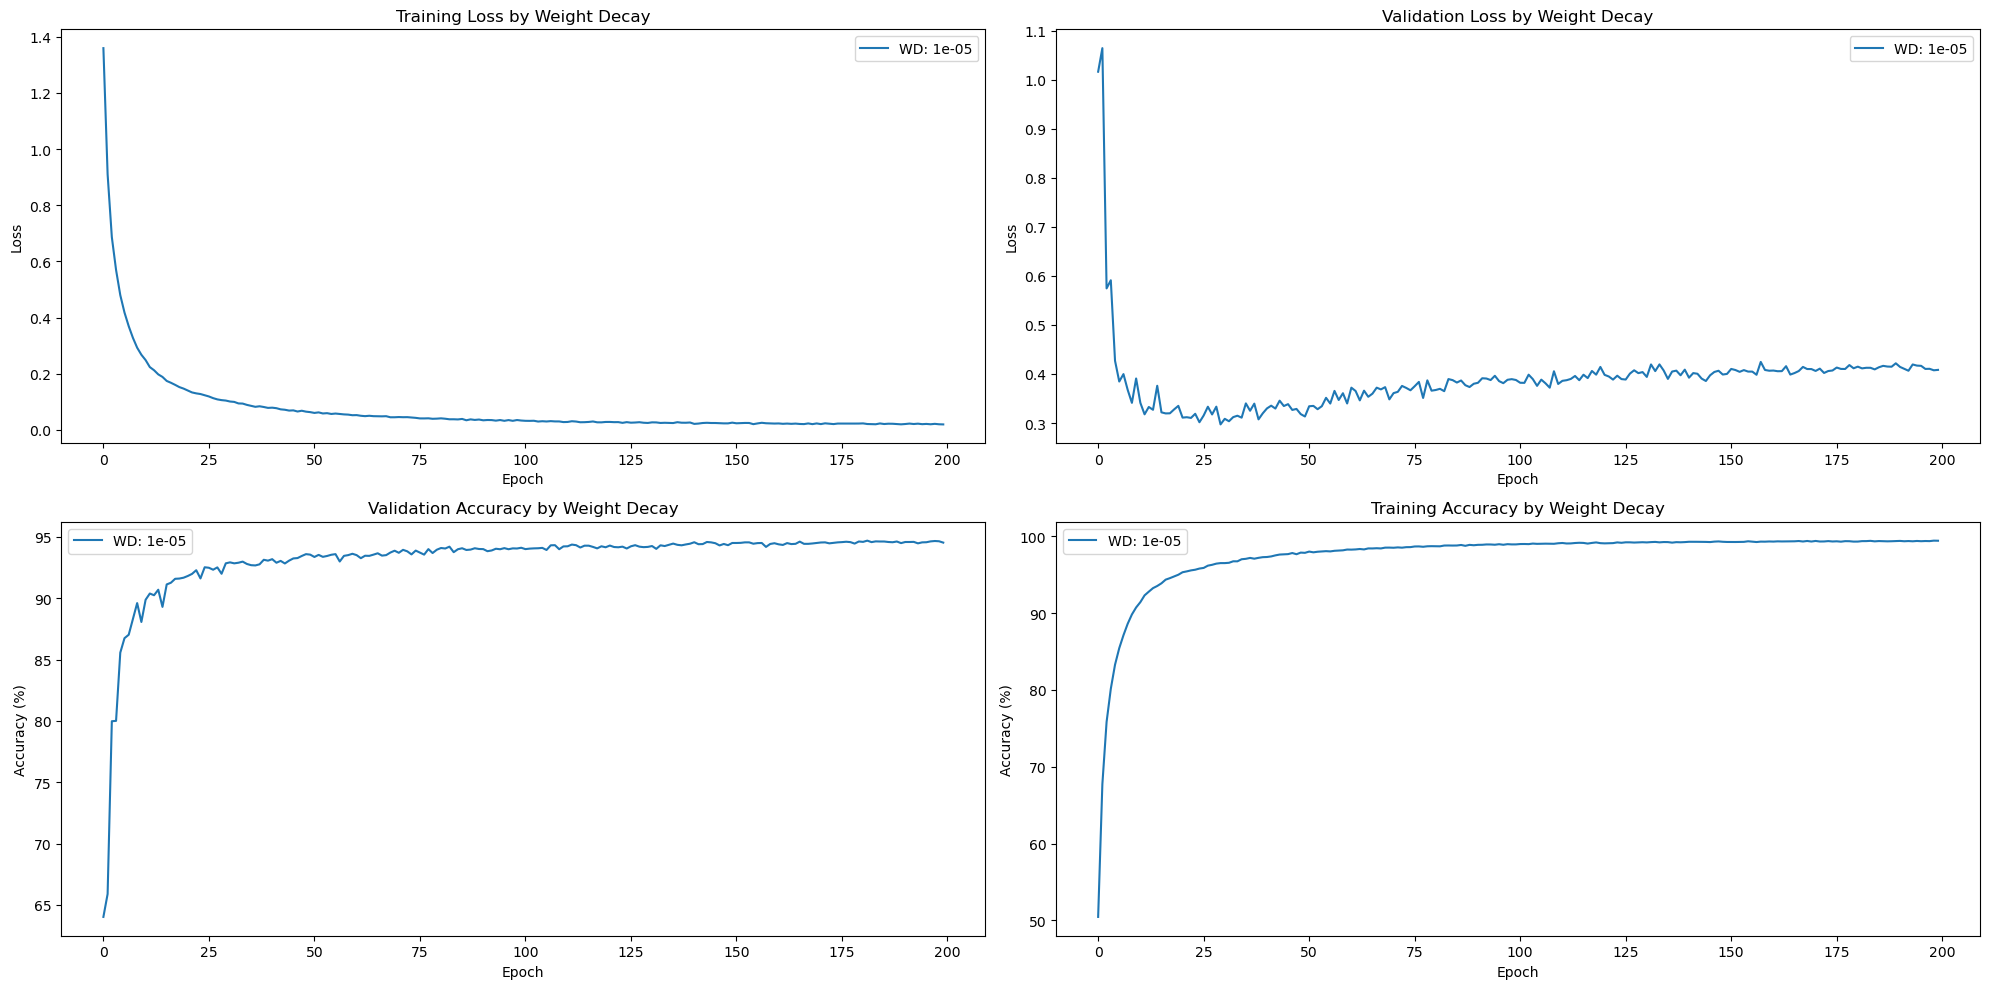

In [12]:
import torch
from torch.optim import AdamW
import matplotlib.pyplot as plt

# Assuming Resnet3_443 is defined and device is set
# model = Resnet3_443().to(device)
weight_decays = [0.00001]
num_epochs = 200  # Or any other number of epochs you want to train for

all_metrics_weight_decay = {
    wd: {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': []}
    for wd in weight_decays
}

for weight_decay in weight_decays:
    print(f"Training with weight decay: {weight_decay}")
    # Re-initialize the model for each weight decay to ensure training starts fresh
    # model = Resnet3_443().to(device)
    metrics = train_and_evaluate_model(model, "Resnet3_443_Exp", loaders, device, weight_decay, num_epochs)
    
    # Unpack and store the returned metrics
    all_metrics_weight_decay[weight_decay]['train_losses'], \
    all_metrics_weight_decay[weight_decay]['valid_losses'], \
    all_metrics_weight_decay[weight_decay]['valid_accuracies'], \
    all_metrics_weight_decay[weight_decay]['train_accuracies'] = metrics

# Plotting
plt.figure(figsize=(20, 10))

# Training Loss
plt.subplot(2, 2, 1)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['train_losses'], label=f'WD: {wd}')
plt.title('Training Loss by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['valid_losses'], label=f'WD: {wd}')
plt.title('Validation Loss by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracya
plt.subplot(2, 2, 3)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['valid_accuracies'], label=f'WD: {wd}')
plt.title('Validation Accuracy by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 4)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['train_accuracies'], label=f'WD: {wd}')
plt.title('Training Accuracy by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# #Training Parameters

# from torch.optim.lr_scheduler import ExponentialLR

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.001)
# scheduler = ExponentialLR(optimizer, gamma=0.98) #changed to .98 prev.99
# num_epochs = 200 
# model_path = 'best_model.pth'



In [25]:
# # Resetting histories
# train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history, learning_rate_history = [], [], [], [], []

# best_accuracy = 0.0
# start_time = time.time()

# for epoch in range(1, num_epochs + 1):
#     model.train()
#     running_loss, total_train_loss, num_batches, correct_train, total_train = 0.0, 0.0, 0, 0, 0
    
#     for i, (inputs, labels) in enumerate(loaders['train_Enhanced']):
#         inputs, labels = inputs.to(device), labels.to(device)
#         labels = labels.long()  # Ensure labels are of the correct dtype
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm= 0.1)

#         optimizer.step()
        
#         running_loss += loss.item()
#         total_train_loss += loss.item()
#         num_batches += 1
        
#         # Calculate predictions for training accuracy
#         pred = outputs.argmax(dim=1, keepdim=True)
#         correct_train += pred.eq(labels.view_as(pred)).sum().item()
#         total_train += labels.size(0)
        
#         # Record the learning rate
#         learning_rate_history.append(optimizer.param_groups[0]['lr'])
        
#         if (i+1) % 100 == 0:
#             print(f"Epoch: {epoch} [{i * len(inputs) + len(inputs)}/{len(loaders['train'].dataset)} "
#                   f"({100. * (i + 1) / len(loaders['train']):.0f}%)]  Loss: {running_loss / 100:.4f}")
#             running_loss = 0.0

#     scheduler.step()  # Update the learning rate
#     avg_train_loss = total_train_loss / num_batches
#     train_accuracy = 100. * correct_train / total_train
    
#     train_loss_history.append(avg_train_loss)
#     train_accuracy_history.append(train_accuracy)
    
#     # Validation phase
#     model.eval()
#     total_valid_loss, correct_valid, num_valid_batches = 0.0, 0, 0
    
#     with torch.no_grad():
#         for inputs, labels in loaders['valid']:
#             inputs, labels = inputs.to(device), labels.to(device)
#             labels = labels.long()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             total_valid_loss += loss.item()
#             pred = outputs.argmax(dim=1, keepdim=True)
#             correct_valid += pred.eq(labels.view_as(pred)).sum().item()
#             num_valid_batches += 1

#     avg_valid_loss = total_valid_loss / num_valid_batches
#     valid_accuracy = 100. * correct_valid / len(datasets['valid'])
    
#     valid_loss_history.append(avg_valid_loss)
#     valid_accuracy_history.append(valid_accuracy)
    
#     print(f"\nEpoch {epoch}: Avg. Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
#           f"Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%\n")
    
#     if valid_accuracy > best_accuracy:
#         best_accuracy = valid_accuracy
#         # Save model, optimizer, and training state
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'scheduler_state_dict': scheduler.state_dict(),
#             'best_accuracy': best_accuracy,
#             'train_loss_history': train_loss_history,
#             'valid_loss_history': valid_loss_history,
#             'valid_accuracy_history': valid_accuracy_history,
#             'train_accuracy_history': train_accuracy_history,
#             'learning_rate_history': learning_rate_history
#         }, model_path)
#         print("Saved best model")

# execution_time = time.time() - start_time
# print(f"Execution time: {execution_time:.2f} seconds")

# # After training, load the best model and evaluate
# # Load the checkpoint
# checkpoint = torch.load(model_path)

# # Extract the model state dict
# model_state_dict = checkpoint['model_state_dict']
# model.eval()

# # Plot the training and validation loss and accuracy
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# axs[0].plot(train_loss_history, '-', linewidth=3, label='Train Loss')
# axs[0].plot(valid_loss_history, '-', linewidth=3, label='Valid Loss')
# axs[0].legend()
# axs[0].set_title('Training and Validation Loss')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Loss')
# axs[0].grid(True)

# axs[1].plot(valid_accuracy_history, '-', linewidth=3, label='Valid Accuracy')
# axs[1].legend()
# axs[1].set_title('Validation Accuracy')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Accuracy (%)')
# axs[1].grid(True)
# plt.tight_layout()
# plt.show()

# # Plot learning rate over batches
# plt.figure(figsize=(10, 5))
# plt.plot(learning_rate_history, '-', linewidth=3, label='Learning Rate')
# plt.legend()
# plt.title('Learning Rate over Batches')
# plt.xlabel('Batch')
# plt.ylabel('Learning Rate')
# plt.grid(True)
# plt.show()


In [20]:
# # Load the checkpoint
# checkpoint = torch.load(model_path)

# # Extract the model state dict
# model_state_dict = checkpoint['model_state_dict']

# # Load the model state dict into the model
# model.load_state_dict(model_state_dict)

# # Optionally, if you want to resume training and need the optimizer and scheduler states:
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# # After loading, you can continue to use your model for evaluation or further training
# model.eval()


model_path = 'Resnet3_443_Exp_Final_best_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()


ResNet3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [24]:

# # After training, load the best model and evaluate
# # model.load_state_dict(torch.load(model_path))
# # model.eval()

# # Plot the training and validation loss and accuracy
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# axs[0].plot(train_loss_history, '-', linewidth=3, label='Train Loss')
# axs[0].plot(valid_loss_history, '-', linewidth=3, label='Valid Loss')
# axs[0].legend()
# axs[0].set_title('Training and Validation Loss')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Loss')
# axs[0].grid(True)

# axs[1].plot(valid_accuracy_history, '-', linewidth=3, label='Valid Accuracy')
# axs[1].legend()
# axs[1].set_title('Validation Accuracy')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Accuracy (%)')
# axs[1].grid(True)
# plt.tight_layout()
# plt.show()

# # Plot learning rate over batches
# plt.figure(figsize=(10, 5))
# plt.plot(learning_rate_history, '-', linewidth=3, label='Learning Rate')
# plt.legend()
# plt.title('Learning Rate over Batches')
# plt.xlabel('Batch')
# plt.ylabel('Learning Rate')
# plt.grid(True)
# plt.show()


In [ ]:
# # Resuming training if required: 
# if os.path.exists(model_path):
#     # Load saved training state
#     checkpoint = torch.load(model_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#     start_epoch = checkpoint['epoch'] + 1  # Continue from next epoch
#     best_accuracy = checkpoint['best_accuracy']
#     train_loss_history = checkpoint['train_loss_history']
#     valid_loss_history = checkpoint['valid_loss_history']
#     valid_accuracy_history = checkpoint['valid_accuracy_history']
#     train_accuracy_history = checkpoint['train_accuracy_history']
#     learning_rate_history = checkpoint['learning_rate_history']
#     print(f"Resuming from epoch {start_epoch} with best valid accuracy {best_accuracy:.2f}%")
# else:
#     start_epoch = 1
#     best_accuracy = 0.0
#     # Initialize histories if not resuming
#     train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history, learning_rate_history = [], [], [], [], []

# # Modify the training loop to start from `start_epoch`
# for epoch in range(start_epoch, num_epochs + 1):
#     model.train()
#     running_loss, total_train_loss, num_batches, correct_train, total_train = 0.0, 0.0, 0, 0, 0
    
#     for i, (inputs, labels) in enumerate(loaders['train']):
#         inputs, labels = inputs.to(device), labels.to(device)
#         labels = labels.long()  # Ensure labels are of the correct dtype
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 0.1)

#         optimizer.step()
        
#         running_loss += loss.item()
#         total_train_loss += loss.item()
#         num_batches += 1
        
#         # Calculate predictions for training accuracy
#         pred = outputs.argmax(dim=1, keepdim=True)
#         correct_train += pred.eq(labels.view_as(pred)).sum().item()
#         total_train += labels.size(0)
        
#         # Record the learning rate
#         learning_rate_history.append(optimizer.param_groups[0]['lr'])
        
#         if (i+1) % 100 == 0:
#             print(f"Epoch: {epoch} [{i * len(inputs) + len(inputs)}/{len(loaders['train'].dataset)} "
#                   f"({100. * (i + 1) / len(loaders['train']):.0f}%)]  Loss: {running_loss / 100:.4f}")
#             running_loss = 0.0

#     scheduler.step()  # Update the learning rate
#     avg_train_loss = total_train_loss / num_batches
#     train_accuracy = 100. * correct_train / total_train
    
#     train_loss_history.append(avg_train_loss)
#     train_accuracy_history.append(train_accuracy)
    
#     # Validation phase
#     model.eval()
#     total_valid_loss, correct_valid, num_valid_batches = 0.0, 0, 0
    
#     with torch.no_grad():
#         for inputs, labels in loaders['valid']:
#             inputs, labels = inputs.to(device), labels.to(device)
#             labels = labels.long()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             total_valid_loss += loss.item()
#             pred = outputs.argmax(dim=1, keepdim=True)
#             correct_valid += pred.eq(labels.view_as(pred)).sum().item()
#             num_valid_batches += 1

#     avg_valid_loss = total_valid_loss / num_valid_batches
#     valid_accuracy = 100. * correct_valid / len(datasets['valid'])
    
#     valid_loss_history.append(avg_valid_loss)
#     valid_accuracy_history.append(valid_accuracy)
    
#     print(f"\nEpoch {epoch}: Avg. Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
#           f"Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%\n")
    
#     if valid_accuracy > best_accuracy:
#         best_accuracy = valid_accuracy
#         # Save model, optimizer, and training state
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'scheduler_state_dict': scheduler.state_dict(),
#             'best_accuracy': best_accuracy,
#             'train_loss_history': train_loss_history,
#             'valid_loss_history': valid_loss_history,
#             'valid_accuracy_history': valid_accuracy_history,
#             'train_accuracy_history': train_accuracy_history,
#             'learning_rate_history': learning_rate_history
#         }, model_path)
#         print("Saved best model")

# execution_time = time.time() - start_time
# print(f"Execution time: {execution_time:.2f} seconds")

# # After training, load the best model and evaluate
# model.load_state_dict(torch.load(model_path))
# model.eval()

# # Plot the training and validation loss and accuracy
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# axs[0].plot(train_loss_history, '-', linewidth=3, label='Train Loss')
# axs[0].plot(valid_loss_history, '-', linewidth=3, label='Valid Loss')
# axs[0].legend()
# axs[0].set_title('Training and Validation Loss')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Loss')
# axs[0].grid(True)

# axs[1].plot(valid_accuracy_history, '-', linewidth=3, label='Valid Accuracy')
# axs[1].legend()
# axs[1].set_title('Validation Accuracy')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Accuracy (%)')
# axs[1].grid(True)
# plt.tight_layout()
# plt.show()

# # Plot learning rate over batches
# plt.figure(figsize=(10, 5))
# plt.plot(learning_rate_history, '-', linewidth=3, label='Learning Rate')
# plt.legend()
# plt.title('Learning Rate over Batches')
# plt.xlabel('Batch')
# plt.ylabel('Learning Rate')
# plt.grid(True)
# plt.show()


# Testing

test images:


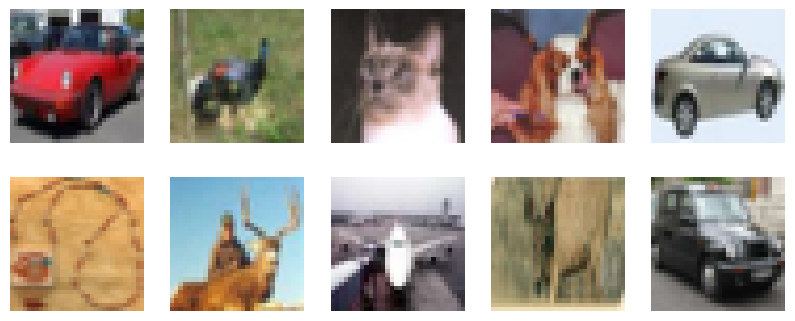

In [21]:
#Visualize Testdata
import numpy as np
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

test_data_dict = unpickle('./data/cifar_test_nolabels.pkl')
test_images = test_data_dict[b'data']
test_images = test_images.reshape(-1, 3, 32, 32)

# Modified function to show random images
def show_original_random_images(images, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    indices = np.random.choice(len(images), rows*cols, replace=False)  # Select random indices
    for i, ax in enumerate(axes.flat):
        # Use the random index to select an image
        img = images[indices[i]].transpose(1, 2, 0)
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.show()

print('test images:')
# Show 10 random original images
show_original_random_images(test_images, rows=2, cols=5)


In [22]:
model_path

'Resnet3_443_Exp_Final_best_model.pth'

In [23]:
#Load Best Model, Normalize test data, do an inference and create submission csv file

# Convert test_images to a float tensor
test_images = torch.from_numpy(test_images).float()

# If the pixel values are in [0,255], scale them to [0,1]
if test_images.max() > 1.0:
    test_images /= 255.0

# Permute the images to [N, C, H, W] format
test_images = test_images.permute(0, 1, 2, 3)


# Define the normalization transform
normalize = transforms.Normalize(*stats) #takes mean and std from loadingand transforming the validation data

# Normalize the images
normalized_images = torch.stack([normalize(img) for img in test_images])

# Make sure your model is on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#load best model.pth
# model.load_state_dict(torch.load('best_model.pth'))
# Load the model state dict into the model



model.load_state_dict(torch.load(model_path))


model.to(device)

# Now, ensure your input data is also sent to the same device
normalized_images = normalized_images.to(device)

model.eval()  # Set the model to evaluation mode

predictions = []
with torch.no_grad():  # No need to track gradients
    for img in normalized_images:
        img = img.unsqueeze(0).to(device)  # Add batch dimension and ensure the tensor is on the right device
        output = model(img)  # Process each image individually
        pred = output.argmax(dim=1)  # Get the index of the max log-probability
        predictions.append(pred.item())
print(len(predictions))

# Create a DataFrame with the ID and predicted Labels
submission_df = pd.DataFrame({
    'ID': list(range(len(predictions))),
    'Labels': predictions
})

# Define the submission CSV file path
submission_csv_path = 'submission.csv'
# Save the DataFrame to a CSV file, without the index
submission_df.to_csv(submission_csv_path, index=False)

# Returning the path to the saved CSV file
submission_csv_path

10000


'submission.csv'